# Colorize point cloud

In [9]:
import numpy as np
import cv2

In [10]:
basedir = '../SemanticKITTI/dataset/sequences/00'
pc_file = f'{basedir}/velodyne/000000.bin'
im_file = f'{basedir}/image_3/000000.png'
calib_file = f'{basedir}/calib.txt'


In [11]:
from colorize.colorize import doColorize
points, pts_valid, colors = doColorize(pc_file, im_file, calib_file)


Number of valid points/ Number of points: 19369/124668 (15.54%)


In [12]:
from projection.spherical_proj import RangeProjection
# projector = RangeProjection(fov_up = 3.0, fov_down = -25.0, proj_w = 2048, proj_h = 64)
# Project the point cloud
# proj_pointcloud, proj_range, proj_idx, proj_mask = projector.doProjection(points)

from projection.scan_unfold import ScanProjection
scan_unfold = ScanProjection(proj_w = 2048, proj_h = 64)
proj_pointcloud, proj_range, proj_idx, proj_mask = scan_unfold.doProjection(points, wrap_around = 1024)

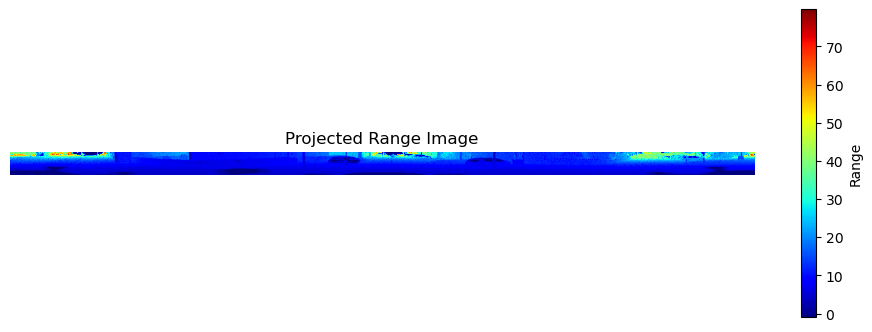

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.imshow(proj_range, cmap='jet')
plt.title('Projected Range Image')
plt.colorbar(label='Range')
plt.axis('off')
plt.show()


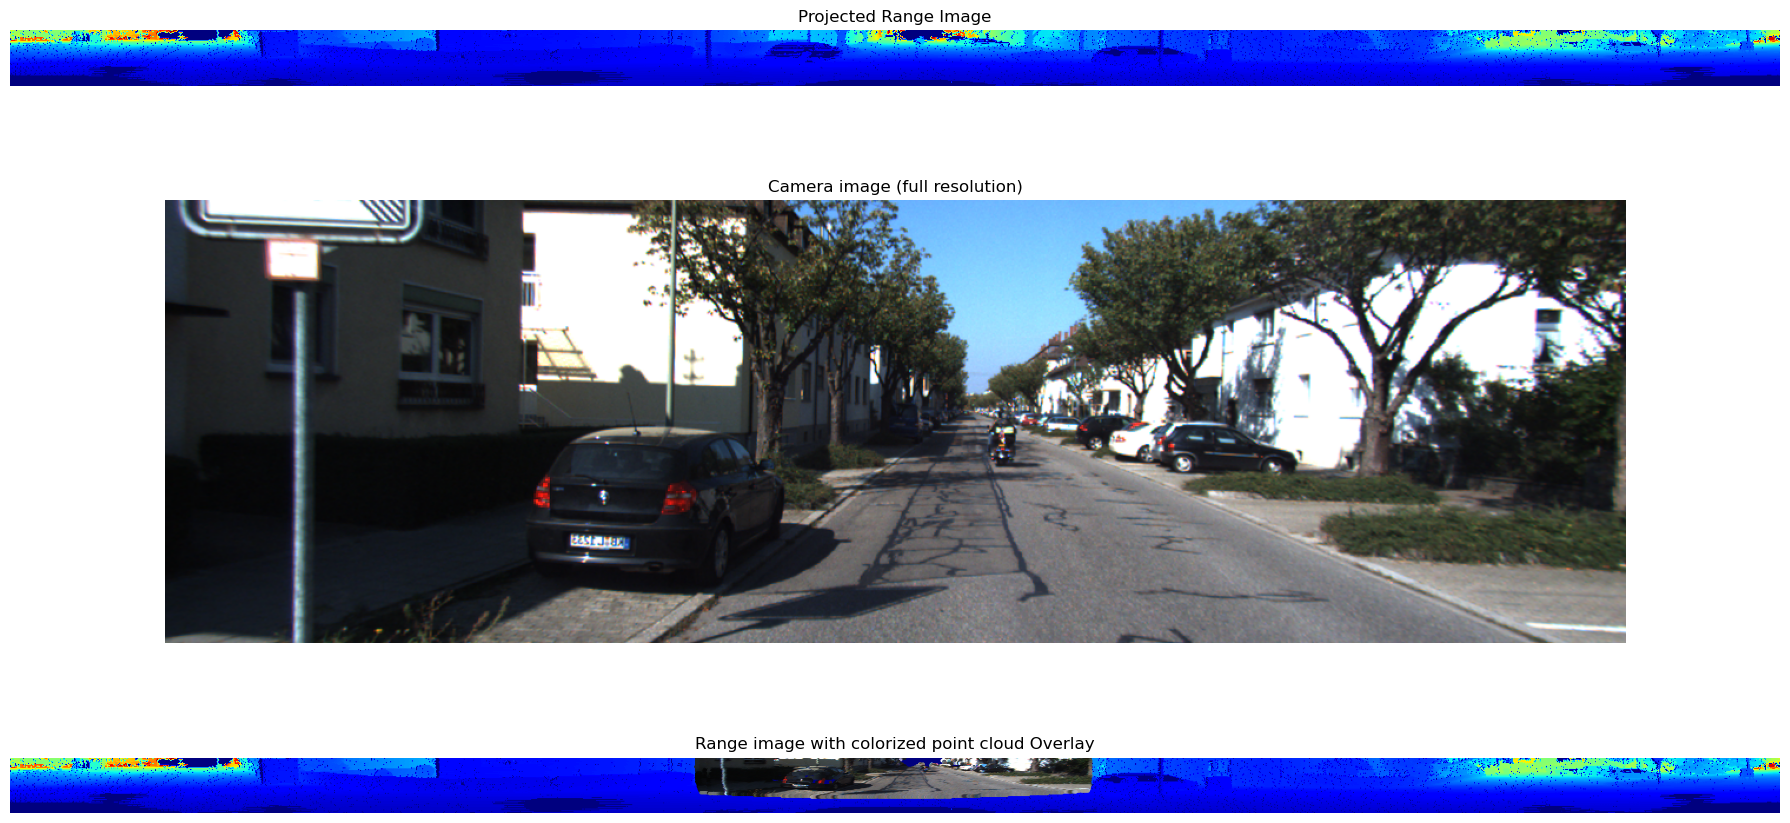

In [14]:
# plot the projected range image with color. If the valid is 1, set the color to the color of the point, otherwise set it to black

fig, axs = plt.subplots(3, 1, figsize=(18, 12))
# 1. Top: proj_range2 as heatmap (no colorbar)
axs[0].imshow(proj_range, cmap='jet')
axs[0].set_title('Projected Range Image')
axs[0].axis('off')

# 2. Middle: show the original image
img = cv2.imread(im_file)
# flip the image horizontally
img = cv2.flip(img, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axs[1].imshow(img)
axs[1].set_title('Camera image (full resolution)')
axs[1].axis('off')

# 3. Bottom: heatmap with colored points overlaid
valid_mask = proj_pointcloud[..., 4] == 1
axs[2].imshow(proj_range, cmap='jet')
ys, xs = np.where(valid_mask)
colors_d = proj_pointcloud[ys, xs, 5:8]
axs[2].scatter(xs, ys, c=colors_d, s=2, marker='o')
axs[2].set_title('Range image with colorized point cloud Overlay')
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [15]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts_valid)
pcd.colors = o3d.utility.Vector3dVector(colors)
# Create a coordinate frame (default size=1.0, origin=[0,0,0])
axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
# Example: rotate by 90 degrees (π/2 radians) 
theta = np.pi / 2  # rotation angle in radians
theta2 = np.pi / 2
# Rotation matrix for x-axis
Rx = np.array([
    [1, 0, 0],
    [0, np.cos(-theta), -np.sin(-theta)],
    [0, np.sin(-theta),  np.cos(-theta)]
])
# Rotation matrix for y-axis
Ry = np.array([
    [ np.cos(theta), 0, np.sin(theta)],
    [ 0,            1, 0           ],
    [-np.sin(theta), 0, np.cos(theta)]
])
Rx2 = np.array([
    [1, 0, 0],
    [0, np.cos(theta/6), -np.sin(theta/6)],
    [0, np.sin(theta/6),  np.cos(theta/6)]
])
pcd.rotate(Rx, center=(0, 0, 0))  # center can be (0,0,0) or pcd.get_center()
pcd.rotate(Ry, center=(0, 0, 0))  # center can be (0,0,0) or pcd.get_center()
pcd.rotate(Rx2, center=(0, 0, 0))  # center can be (0,0,0) or pcd.get_center()

o3d.visualization.draw_geometries([pcd, axis])



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Dropped Escape call with ulEscapeCode : 0x03007703
